In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress


In [2]:
def right_handed_percentage(group):
    right_handed_count = group[group['hand'] == 'R'].shape[0]
    total_known_hand_count = group[group['hand'].isin(['R', 'L'])].shape[0]
    if total_known_hand_count == 0:
        return 0
    return (right_handed_count / total_known_hand_count) * 100

In [3]:
files = [   
    'data/atp_rankings_70s.csv',
    'data/atp_rankings_80s.csv',
    'data/atp_rankings_90s.csv',
    'data/atp_rankings_00s.csv',
    'data/atp_rankings_10s.csv',
    'data/atp_rankings_20s.csv',
    'data/atp_rankings_current.csv'
]

rankings_df_list = [pd.read_csv(file) for file in files]
rankings_df = pd.concat(rankings_df_list, ignore_index=True)

players_df = pd.read_csv('data/atp_players.csv')

filenames = [f'data/atp_matches_{i}.csv' for i in range(1968, 2025)]
years = list(range(1968, 2025))
atp_matches_df_list = [pd.read_csv(filename) for filename in filenames]
atp_matches_df = pd.concat(atp_matches_df_list, ignore_index=True)

### ATP rankings

In [4]:
atp_matches_df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

In [5]:
players_df['dob'] = pd.to_datetime(players_df['dob'], format='%Y%m%d', errors='coerce')
rankings_df['ranking_date'] = pd.to_datetime(rankings_df['ranking_date'], format='%Y%m%d', errors='coerce')

In [6]:
merged_df = pd.merge(rankings_df[rankings_df['points'] >= 68], players_df, left_on='player', right_on='player_id', how='left')

In [7]:
merged_df.drop('wikidata_id', inplace=True, axis=1)

In [8]:

merged_df['ranking_date'] = pd.to_datetime(merged_df['ranking_date'], errors='coerce')
merged_df['age'] = ((merged_df['ranking_date'] - merged_df['dob']).dt.days / 365.25).round(2)
merged_df = merged_df[merged_df['age'] >= 10]

### Data for the plots

In [37]:
height_data = merged_df['height']
print(height_data.mean())
atp_matches_df['tourney_date'] = pd.to_datetime(atp_matches_df['tourney_date'], format='%Y%m%d', errors='coerce')


184.5373500735316


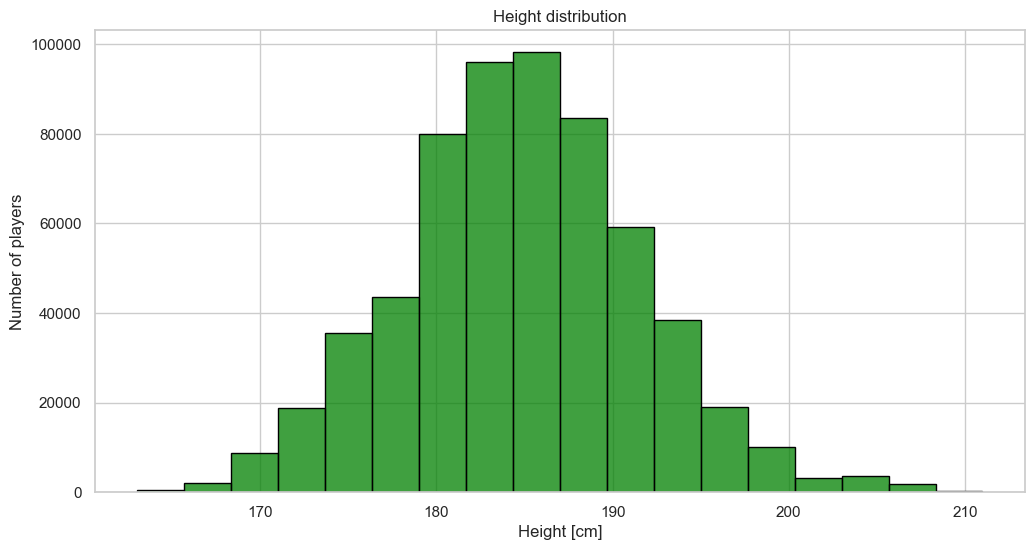

In [26]:
# height distribution
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(12, 6))
sns.histplot(height_data, bins=18, kde=False, color='green', edgecolor='black')
plt.title('Height distribution')
plt.xlabel('Height [cm]')
plt.ylabel('Number of players')
plt.show()

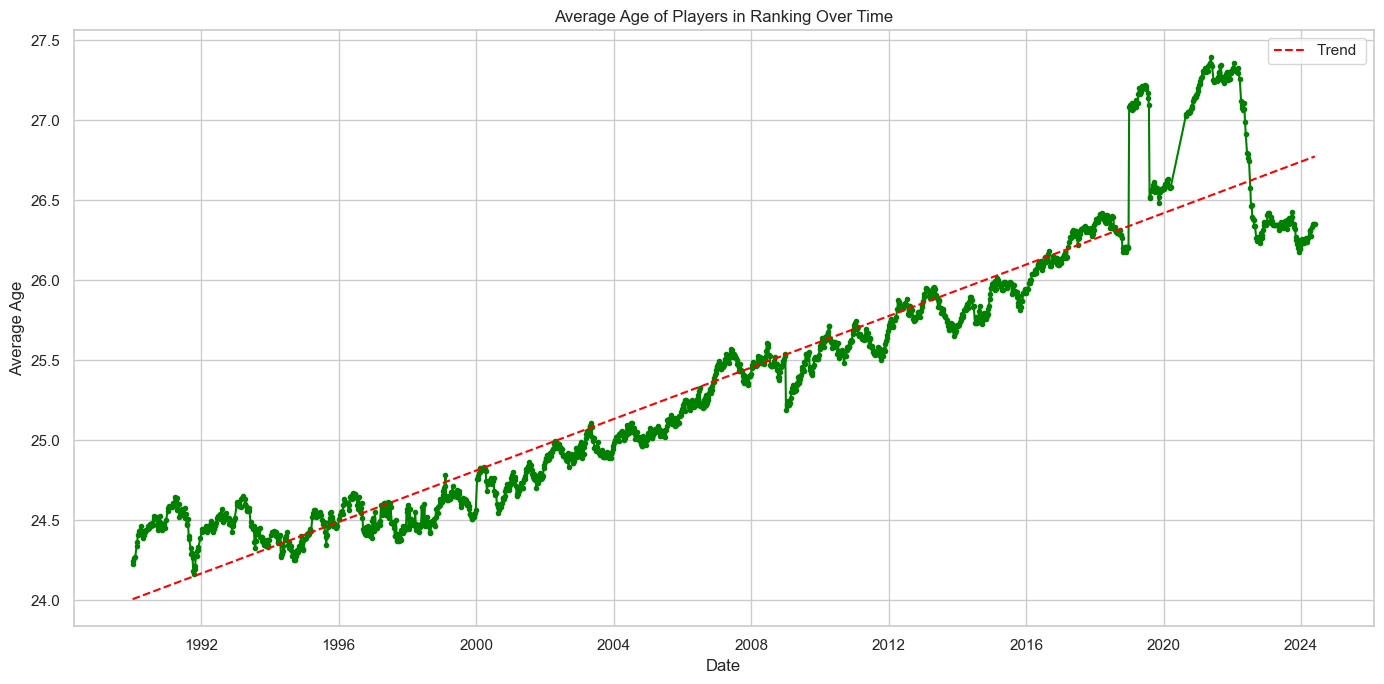

Pearson correlation coefficient: 0.95


In [38]:
average_age_per_date = merged_df.groupby('ranking_date')['age'].mean()

plt.figure(figsize=(14, 7))
plt.plot(average_age_per_date.index, average_age_per_date.values, linestyle='-', marker='.', color='green')
plt.xlabel('Date')
plt.ylabel('Average Age')
plt.title('Average Age of Players in Ranking Over Time')
plt.grid(True)

x = mdates.date2num(average_age_per_date.index)  
y = average_age_per_date.values
slope, intercept, r_value, _, _ = linregress(x, y)
trend = intercept + slope * x

plt.plot(average_age_per_date.index, trend, linestyle='--', color='red', label=f'Trend ')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.legend()
plt.show()

print(f"Pearson correlation coefficient: {r_value:.2f}")


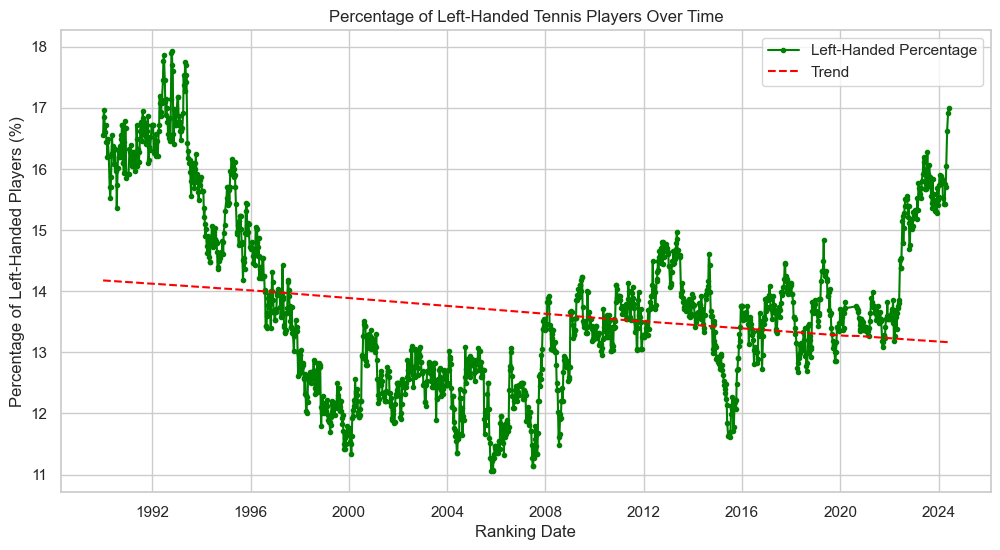

Pearson correlation coefficient: -0.21


In [30]:
filtered_df = merged_df[merged_df['hand'].isin(['L', 'R'])]

grouped_df = filtered_df.groupby('ranking_date').apply(lambda x: x['hand'].value_counts(normalize=True)).unstack().fillna(0)
left_handed_percentage = grouped_df['L'] * 100

x = np.arange(len(left_handed_percentage))
y = left_handed_percentage.values

slope, intercept, r_value, _, _ = linregress(x, y)
trend = intercept + slope * x

plt.figure(figsize=(14, 7))
plt.plot(left_handed_percentage.index, left_handed_percentage, label='Left-Handed Percentage', marker='.', linestyle='-', color='green')
plt.plot(left_handed_percentage.index, trend, label=f'Trend', color='red', linestyle='--')
plt.title('Percentage of Left-Handed Tennis Players Over Time')
plt.xlabel('Ranking Date')
plt.ylabel('Percentage of Left-Handed Players (%)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Pearson correlation coefficient: {r_value:.2f}")


453.82149067256296
442.2078169910799


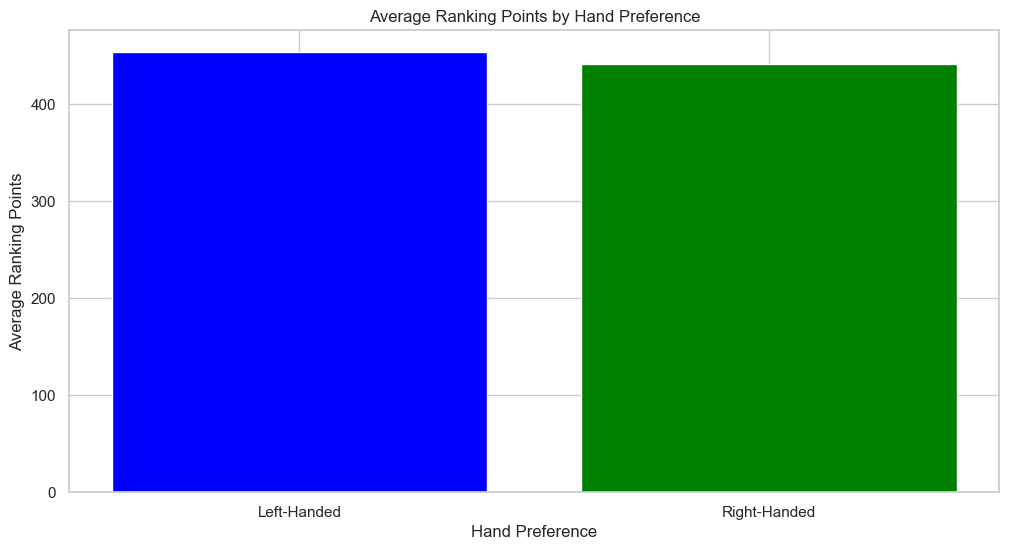

In [39]:
# which hand gain more points
left_handed = merged_df[merged_df['hand'] == 'L']
right_handed = merged_df[merged_df['hand'] == 'R']
mean_points_left = left_handed['points'].mean()
mean_points_right = right_handed['points'].mean()
print(mean_points_left)
print(mean_points_right)
plt.figure(figsize=(12, 6))
plt.bar(['Left-Handed', 'Right-Handed'], [mean_points_left, mean_points_right], color=['blue', 'green'])
plt.title('Average Ranking Points by Hand Preference')
plt.xlabel('Hand Preference')
plt.ylabel('Average Ranking Points')
plt.grid(True)
plt.show()

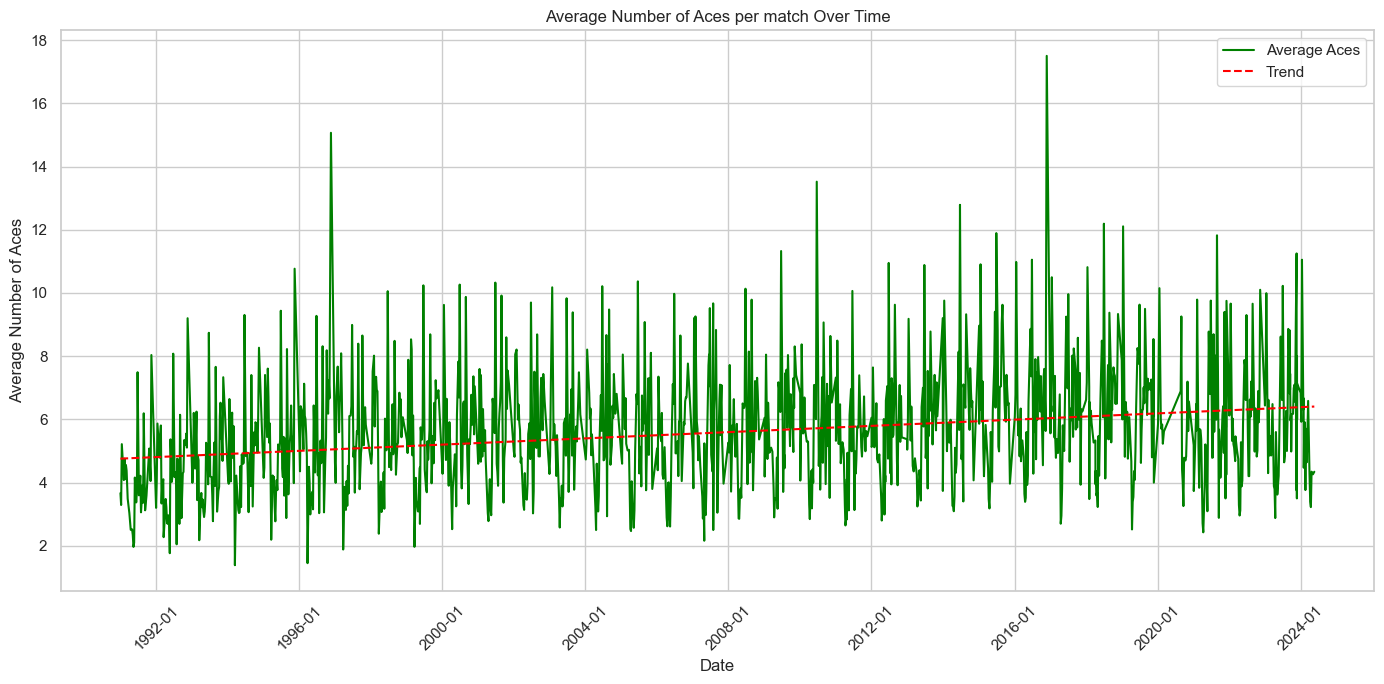

Pearson correlation coefficient: 0.26


In [31]:
aces_over_time_clean = atp_matches_df[['tourney_date', 'w_ace', 'l_ace']].dropna()
aces_over_time_clean = aces_over_time_clean[(aces_over_time_clean['w_ace'] >= 0) & (aces_over_time_clean['l_ace'] >= 0)]

aces_over_time_clean['average_aces'] = (aces_over_time_clean['w_ace'] + aces_over_time_clean['l_ace']) / 2

aces_over_time_grouped = aces_over_time_clean.groupby('tourney_date')['average_aces'].mean().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(aces_over_time_grouped['tourney_date'], aces_over_time_grouped['average_aces'], label='Average Aces', color='green')
plt.xlabel('Date')
plt.ylabel('Average Number of Aces')
plt.title('Average Number of Aces per match Over Time')
plt.legend()
plt.grid(True)

x_values = pd.to_datetime(aces_over_time_grouped['tourney_date']).astype(int) / 10**9  
y_values = aces_over_time_grouped['average_aces'].values
slope, intercept, r_value, _, _ = linregress(x_values, y_values)
trend = intercept + slope * x_values

plt.plot(aces_over_time_grouped['tourney_date'], trend, linestyle='--', color='red', label=f'Trend')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

print(f"Pearson correlation coefficient: {r_value:.2f}")


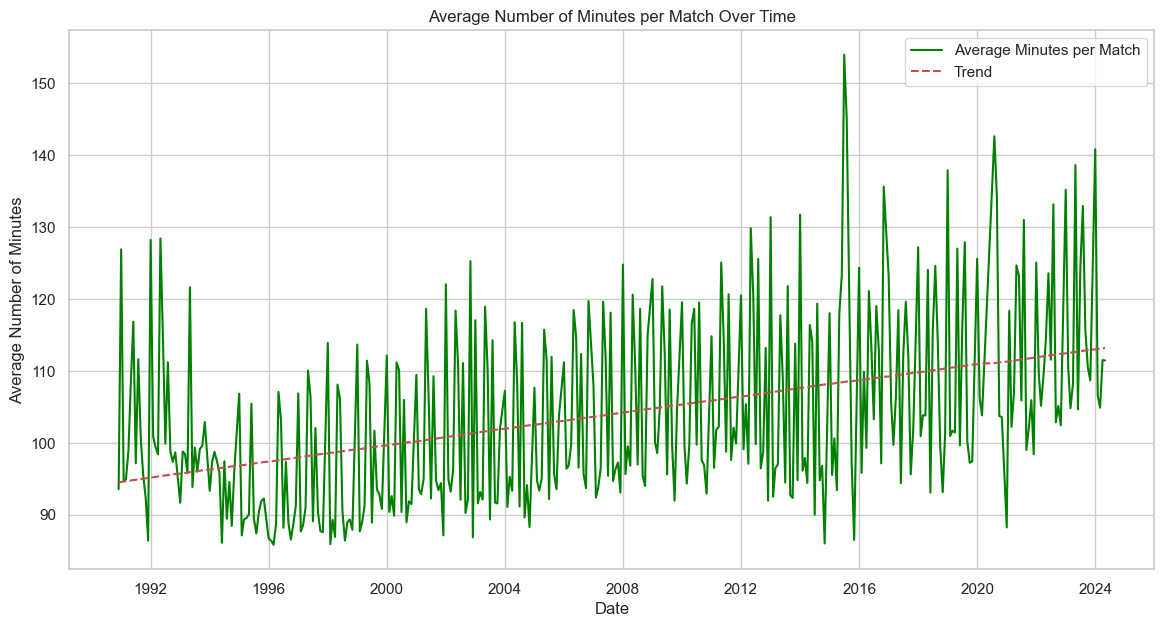

Pearson correlation coefficient: 0.42


In [32]:

atp_matches_df['year'] = atp_matches_df['tourney_date'].dt.year
atp_matches_df['month'] = atp_matches_df['tourney_date'].dt.month
atp_matches_df = atp_matches_df[atp_matches_df['tourney_date'].dt.year >= 1990]

minutes_over_time = atp_matches_df.groupby(['year', 'month'])['minutes'].mean().reset_index()

minutes_over_time['date'] = pd.to_datetime(minutes_over_time[['year', 'month']].assign(day=1))
minutes_over_time = minutes_over_time.dropna(subset=['minutes'])

x = np.arange(len(minutes_over_time))
y = minutes_over_time['minutes']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
trend = intercept + slope * x
r_value = r_value.round(2)

plt.figure(figsize=(14, 7))
plt.plot(minutes_over_time['date'], minutes_over_time['minutes'], label='Average Minutes per Match', color='green')
plt.plot(minutes_over_time['date'], trend, label='Trend', color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average Number of Minutes')
plt.title('Average Number of Minutes per Match Over Time')
plt.legend()
plt.grid(True)
plt.show()


print(f"Pearson correlation coefficient: {r_value}")

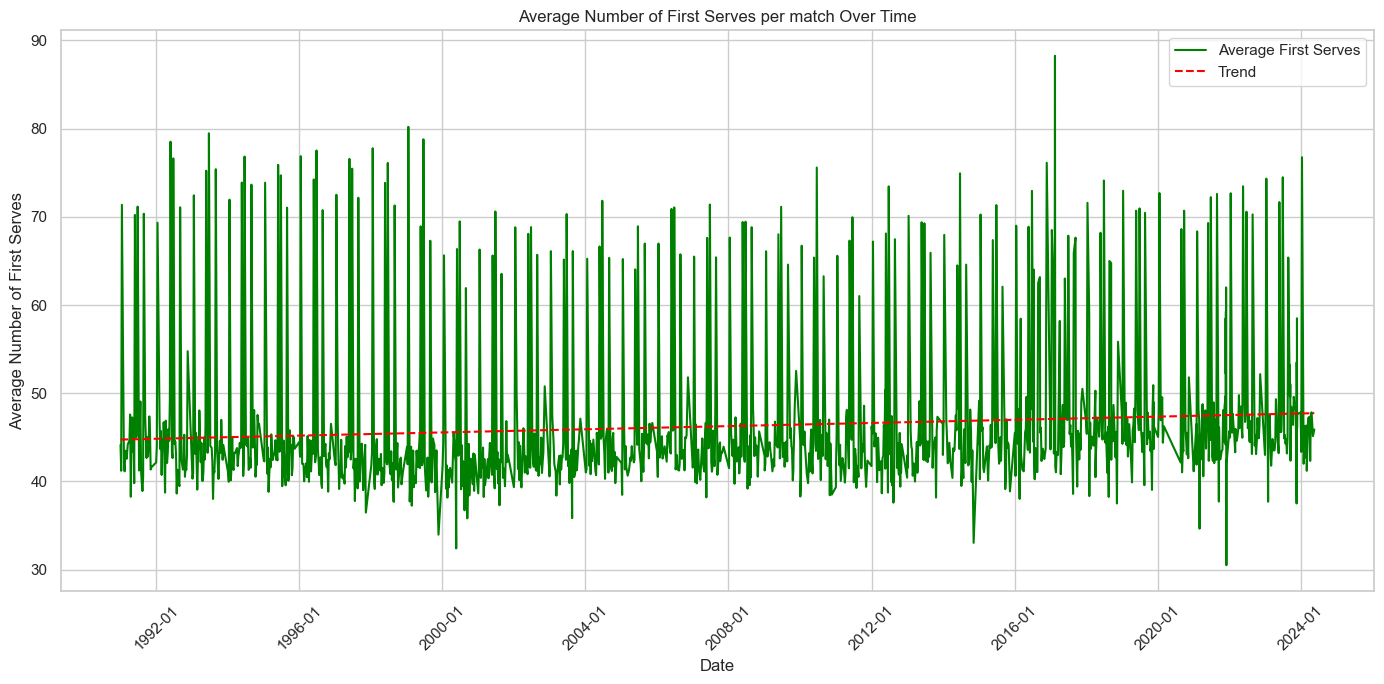

Pearson correlation coefficient: 0.10


In [40]:
first_serves_over_time_clean = atp_matches_df[['tourney_date', 'w_1stIn', 'l_1stIn']].dropna()
first_serves_over_time_clean = first_serves_over_time_clean[(first_serves_over_time_clean['w_1stIn'] >= 0) & (first_serves_over_time_clean['l_1stIn'] >= 0)]

first_serves_over_time_clean['average_first_serves'] = (first_serves_over_time_clean['w_1stIn'] + first_serves_over_time_clean['l_1stIn']) / 2

first_serves_over_time_grouped = first_serves_over_time_clean.groupby('tourney_date')['average_first_serves'].mean().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(first_serves_over_time_grouped['tourney_date'], first_serves_over_time_grouped['average_first_serves'], label='Average First Serves', color='green')
plt.xlabel('Date')
plt.ylabel('Average Number of First Serves')
plt.title('Average Number of First Serves per match Over Time')
plt.legend()
plt.grid(True)


x_values = pd.to_datetime(first_serves_over_time_grouped['tourney_date']).astype(int) / 10**9
y_values = first_serves_over_time_grouped['average_first_serves'].values
slope, intercept, r_value, _, _ = linregress(x_values, y_values)
trend = intercept + slope * x_values

plt.plot(first_serves_over_time_grouped['tourney_date'], trend, linestyle='--', color='red', label=f'Trend')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

print(f"Pearson correlation coefficient: {r_value:.2f}")


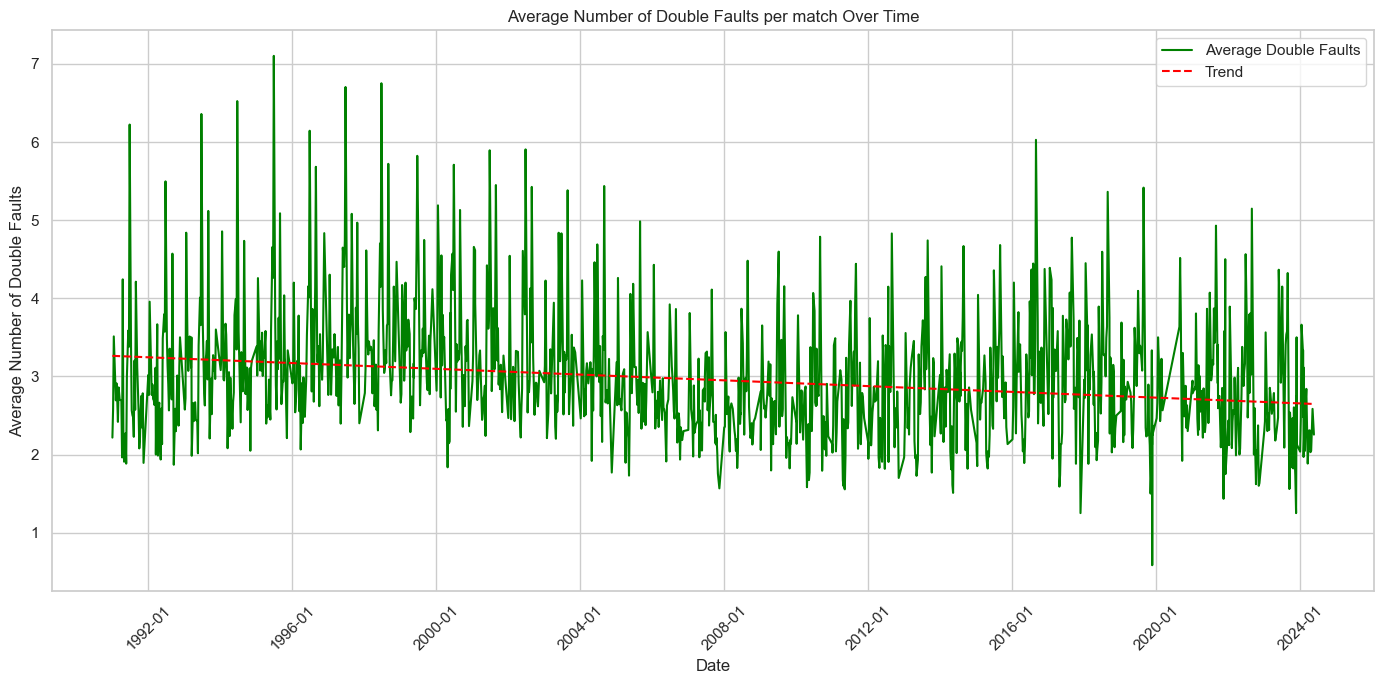

Pearson correlation coefficient: -0.23


In [17]:
errors_over_time_clean = atp_matches_df[['tourney_date', 'w_df', 'l_df']].dropna()
errors_over_time_clean = errors_over_time_clean[(errors_over_time_clean['w_df'] >= 0) & (errors_over_time_clean['l_df'] >= 0)]
errors_over_time_clean['average_errors'] = (errors_over_time_clean['w_df'] + errors_over_time_clean['l_df']) / 2
errors_over_time_grouped = errors_over_time_clean.groupby('tourney_date')['average_errors'].mean().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(errors_over_time_grouped['tourney_date'], errors_over_time_grouped['average_errors'], label='Average Double Faults', color='green')
plt.xlabel('Date')
plt.ylabel('Average Number of Double Faults')
plt.title('Average Number of Double Faults per match Over Time')
plt.legend()
plt.grid(True)

x_values = pd.to_datetime(errors_over_time_grouped['tourney_date']).astype(int) / 10**9 
y_values = errors_over_time_grouped['average_errors'].values
slope, intercept, r_value, _, _ = linregress(x_values, y_values)
trend = intercept + slope * x_values

plt.plot(errors_over_time_grouped['tourney_date'], trend, linestyle='--', color='red', label=f'Trend')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

print(f"Pearson correlation coefficient: {r_value:.2f}")

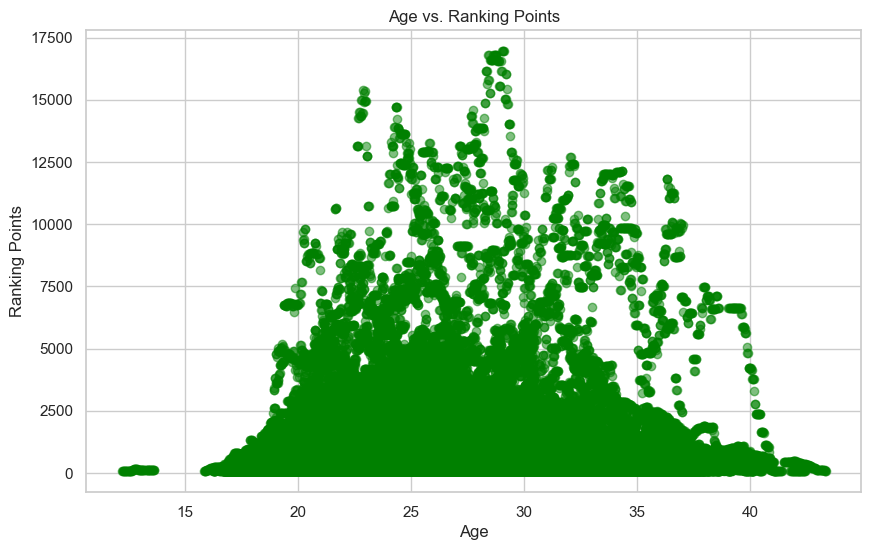

Pearson correlation coefficient: 0.1159


In [18]:
# correlation between age and points in ATP 
data = merged_df[['age', 'points']].dropna()
corr, _ = pearsonr(data['age'], data['points'])
corr = corr.round(4)
plt.figure(figsize=(12, 6))
plt.scatter(data['age'], data['points'], alpha=0.5, color='green')
plt.title('Age vs. Ranking Points')
plt.xlabel('Age')
plt.ylabel('Ranking Points')
plt.grid(True)
plt.show()

print(f"Pearson correlation coefficient: {corr}")

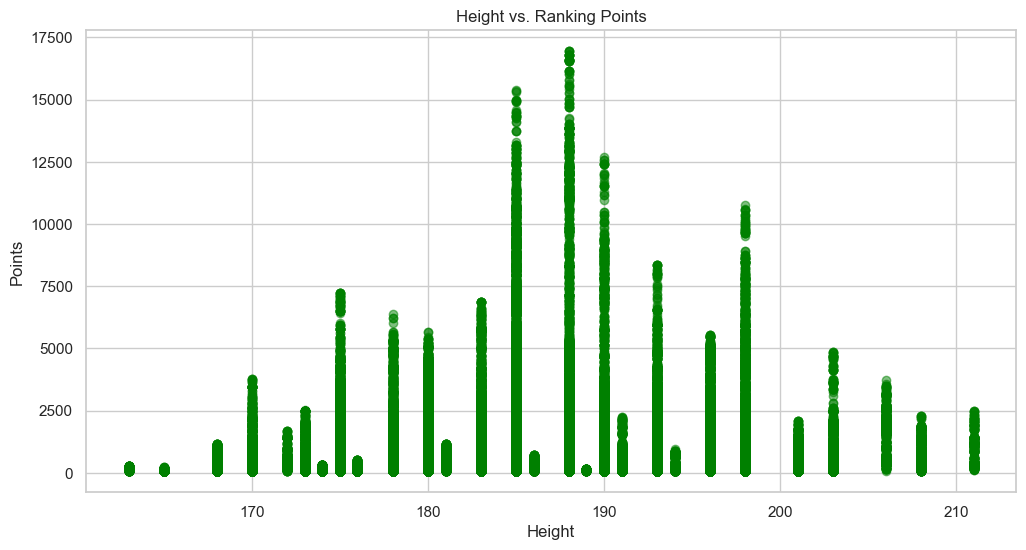

Pearson's correlation coefficient: 0.11


In [34]:
data = merged_df[['height', 'points']].dropna()

corr, _ = pearsonr(data['height'], data['points'])

plt.figure(figsize=(12, 6))
plt.scatter(data['height'], data['points'], alpha=0.5, color='green')
plt.title(f'Height vs. Ranking Points')
plt.xlabel('Height')
plt.ylabel('Points')
plt.grid(True)
plt.show()

print(f"Pearson's correlation coefficient: {corr:.2f}")

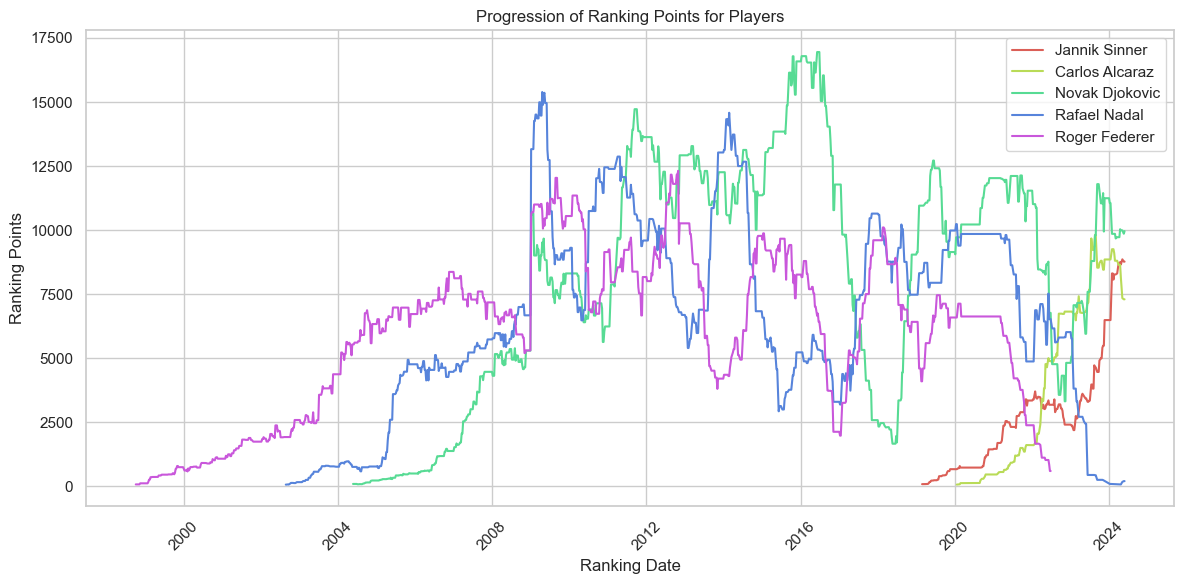

In [35]:
players = [206173, 207989, 104925, 104745, 103819]
colors = sns.color_palette('hls', len(players))

plt.figure(figsize=(12, 6))

for player_id, color in zip(players, colors):
    player_data = merged_df[merged_df['player_id'] == player_id]
    player_data = player_data.sort_values(by='ranking_date')
    player_name = player_data.iloc[0]['name_first'] + ' ' + player_data.iloc[0]['name_last']
    plt.plot(player_data['ranking_date'], player_data['points'], marker='', linestyle='-', color=color, label=player_name)

plt.title('Progression of Ranking Points for Players')
plt.xlabel('Ranking Date')
plt.ylabel('Ranking Points')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


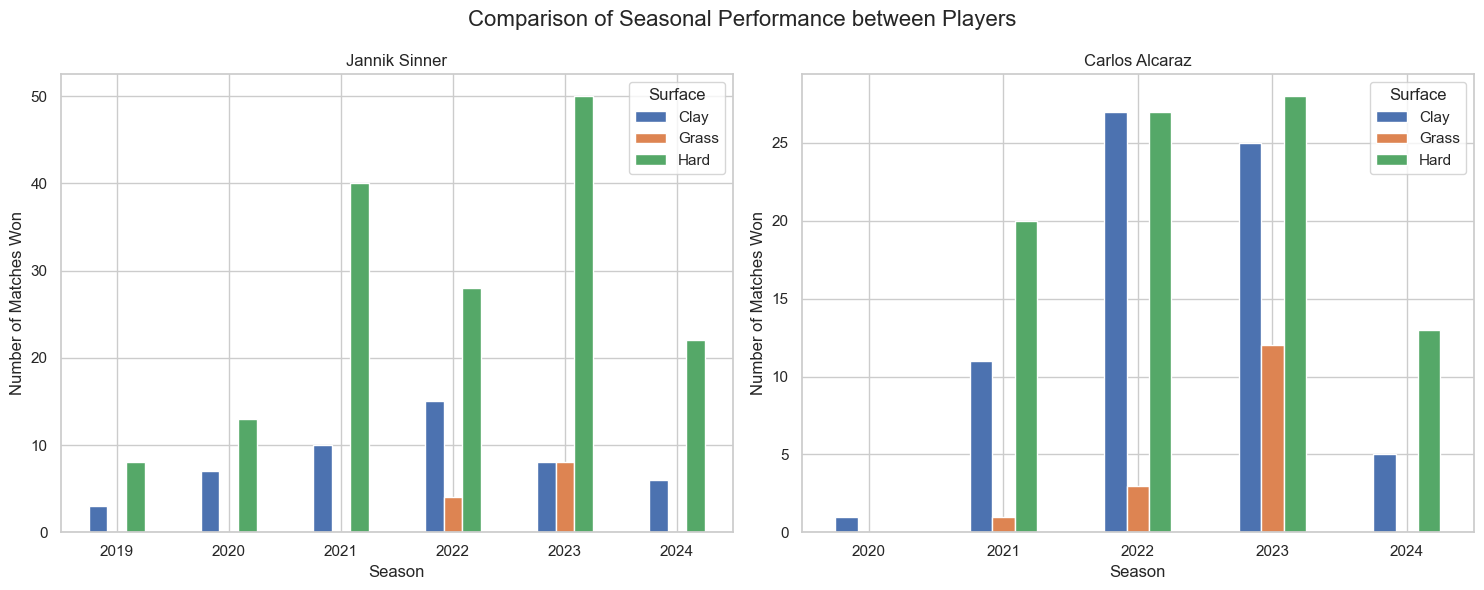

In [24]:
# surface analysis

players = [206173, 207989]
player_matches = atp_matches_df[atp_matches_df['winner_id'].isin(players)].copy() 

player_matches.loc[:, 'tourney_date'] = pd.to_datetime(player_matches['tourney_date'], format='%Y%m%d')

player_names = {}
for player_id in players:
    player_data = player_matches[player_matches['winner_id'] == player_id].iloc[0]
    player_names[player_id] = f"{player_data['winner_name']}"

seasonal_analysis = player_matches.groupby(['winner_id', player_matches['tourney_date'].dt.year, 'surface']).size().unstack()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for i, player_id in enumerate(players):
    data = seasonal_analysis.loc[player_id]
    player_name = player_names[player_id]
    data.plot(kind='bar', ax=axes[i], rot=0, title=f'{player_name}')
    axes[i].set_xlabel('Season')
    axes[i].set_ylabel('Number of Matches Won')
    axes[i].legend(title='Surface')

plt.suptitle('Comparison of Seasonal Performance between Players', fontsize=16)
plt.tight_layout()
plt.show()

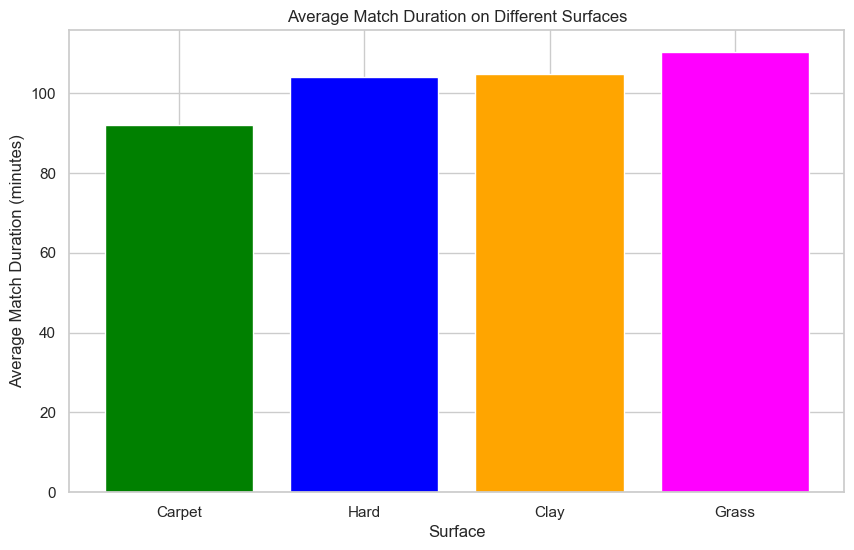

  surface  minutes
0  Carpet    92.03
3    Hard   104.06
1    Clay   104.88
2   Grass   110.25


In [22]:
matches_data = atp_matches_df[['surface', 'minutes']].copy()

matches_data.dropna(subset=['minutes'], inplace=True)
matches_data = matches_data[matches_data['minutes'] > 0]

average_duration_per_surface = matches_data.groupby('surface')['minutes'].mean().reset_index()
average_duration_per_surface = average_duration_per_surface.round({'minutes': 2})
average_duration_per_surface.sort_values(by='minutes', inplace=True)


plt.figure(figsize=(12, 6))
plt.bar(average_duration_per_surface['surface'], average_duration_per_surface['minutes'], color=['green', 'blue', 'orange', 'magenta'])
plt.title('Average Match Duration on Different Surfaces')
plt.xlabel('Surface')
plt.ylabel('Average Match Duration (minutes)')
plt.grid(True)
plt.show()

print(average_duration_per_surface)